In [1]:
# ==============================================================================
# CELL 1: SETUP AND INSTALLATION
# ==============================================================================
print("🚀 Starting complete setup for Prithvi (Manual Loading)...")

# --- 1. Install required packages ---
print("⏳ Installing required packages...")
!pip install -q einops timm transformers huggingface_hub webdataset torch torchvision torchaudio albumentations fsspec braceexpand zarr==2.18.0 numcodecs==0.15.1
print("✅ Packages installed.")

# --- 2. Download the TerraMesh data loader script ---
print("\n⏳ Downloading the terramesh.py helper script...")
!wget -q https://huggingface.co/datasets/ibm-esa-geospatial/TerraMesh/resolve/main/terramesh.py
print("✅ terramesh.py downloaded.")

# ==============================================================================
# CELL 2: IMPORTS AND CONFIGURATION
# ==============================================================================
import torch
import torch.nn as nn
import numpy as np
import time
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import DataLoader
import terramesh

# --- Configuration ---
print("\n⚙️ Setting up configuration...")
NUM_LULC_CLASSES = 11
INPUT_SIZE = (96, 96) 
BANDS_IDXS = [1, 2, 3, 8, 10, 11]
BATCH_SIZE = 128
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Configuration loaded. Using device: {DEVICE}")

# ==============================================================================
# CELL 3: DATA TRANSFORMATION
# ==============================================================================
image_mean = [0.0343, 0.0469, 0.0475, 0.2038, 0.1306, 0.0838]
image_std = [0.035, 0.0425, 0.0553, 0.081, 0.0701, 0.0618]

class PrithviTransform:
    def __init__(self, band_idxs, input_size, image_mean, image_std):
        self.transform = A.Compose([
            A.Resize(height=input_size[0], width=input_size[1]),
            A.Normalize(mean=image_mean, std=image_std),
            ToTensorV2(),
        ], additional_targets={'mask': 'mask'})
        self.band_idxs = band_idxs

    def __call__(self, sample):
        image = sample['S2L2A']
        mask = sample['LULC']
        selected_bands_image = image[self.band_idxs, :, :]
        selected_bands_image = np.transpose(selected_bands_image, (1, 2, 0))
        mask_2d = mask[0]
        transformed = self.transform(image=selected_bands_image, mask=mask_2d)
        return {'pixel_values': transformed['image'], 'labels': transformed['mask'].squeeze().long()}

data_transform = PrithviTransform(BANDS_IDXS, INPUT_SIZE, image_mean, image_std)
print("✅ Prithvi data transformation pipeline is ready.")

# ==============================================================================
# CELL 4: PRITHVI MODEL DEFINITION (MANUAL LOADING)
# ==============================================================================
print("\n🏗️ Defining and MANUALLY loading the Prithvi model...")

# --- Step 1: Download the custom model code and the weight file ---
print("⏳ Downloading Prithvi model definition (prithvi_mae.py)...")
!wget -q https://huggingface.co/ibm-nasa-geospatial/Prithvi-EO-2.0-300M/resolve/main/prithvi_mae.py

print("⏳ Downloading Prithvi model weights (Prithvi_EO_V2_300M.pt)...")
!wget -q https://huggingface.co/ibm-nasa-geospatial/Prithvi-EO-2.0-300M/resolve/main/Prithvi_EO_V2_300M.pt

# --- Step 2: Import the CORRECT model class and create an instance ---
# --- FINAL FIX #1 --- The correct class name is PrithviViT
from prithvi_mae import PrithviViT

# Use the correct 600M parameters
encoder = PrithviViT(
    img_size=INPUT_SIZE[0], patch_size=16, in_chans=6,
    embed_dim=1024, depth=24, num_heads=16, mlp_ratio=4
)

# --- Step 3: Load the weights and remove problematic keys ---
state_dict = torch.load('Prithvi_EO_V2_300M.pt', map_location='cpu')
if 'pos_embed' in state_dict:
    del state_dict['pos_embed']
for key in list(state_dict.keys()):
    if 'pos_embed' in key: # Catch any other pos_embed keys
        del state_dict[key]

encoder.to(DEVICE)
encoder.load_state_dict(state_dict, strict=False)
print("✅ Prithvi encoder manually loaded with pre-trained weights onto the GPU.")

# --- Step 4: Wrap the encoder with our segmentation head ---
class PrithviSegmentationModel(nn.Module):
    def __init__(self, encoder, num_classes):
        super().__init__()
        self.vit = encoder
        hidden_size = self.vit.embed_dim
        self.segmentation_head = nn.Sequential(
            nn.Conv2d(hidden_size, num_classes, kernel_size=1),
            nn.Upsample(size=INPUT_SIZE, mode='bilinear', align_corners=False)
        )

    def forward(self, pixel_values):
        # The forward_features method returns a list of outputs from each block
        features_list = self.vit.forward_features(pixel_values)
        # We need the output of the final block for segmentation
        patch_embeddings = features_list[-1]
        # Remove the [CLS] token embedding
        patch_embeddings = patch_embeddings[:, 1:, :]
        
        batch_size, num_patches, hidden_size = patch_embeddings.shape
        grid_size = int(num_patches**0.5)
        feature_map = patch_embeddings.reshape(batch_size, grid_size, grid_size, hidden_size).permute(0, 3, 1, 2)
        return self.segmentation_head(feature_map)

# ==============================================================================
# CELL 5: FINAL DATALOADER AND MODEL TEST
# ==============================================================================
print("\n⏳ Initializing DataLoader and testing the full pipeline...")

val_dataset = terramesh.build_terramesh_dataset(
    path="https://huggingface.co/datasets/ibm-esa-geospatial/TerraMesh/resolve/main/",
    modalities=['S2L2A', 'LULC'],
    transform=data_transform,
    split="val",
    shuffle=False,
    batch_size=BATCH_SIZE
)
val_dataloader = DataLoader(val_dataset, batch_size=None, num_workers=0)

model = PrithviSegmentationModel(encoder=encoder, num_classes=NUM_LULC_CLASSES)
model.to(DEVICE)

try:
    with torch.no_grad():
        test_batch = next(iter(val_dataloader))
        pixel_values = test_batch['pixel_values'].to(DEVICE)
        labels = test_batch['labels'].to(DEVICE)
        
        # --- FINAL FIX #2 --- The PrithviViT model handles the 4D to 5D conversion internally.
        # We can pass our 4D tensor directly.
        output = model(pixel_values)
        
        print("\n🎉🎉🎉 SUCCESS! The Prithvi CNN pipeline is working. 🎉🎉🎉")
        print(f"  - Input shape: {pixel_values.shape}")
        print(f"  - Labels shape: {labels.shape}")
        print(f"  - Model output shape: {output.shape}")

except Exception as e:
    print(f"\n❌ A critical error occurred: {e}")

🚀 Starting complete setup for Prithvi (Manual Loading)...
⏳ Installing required packages...
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 5.5 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 72.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 84.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 62.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 49.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.0 MB/s eta 0:00:00:00:

In [2]:
from tqdm import tqdm 

# ==============================================================================
# FINAL CELL: TRAINING SETUP AND LOOP (WITH LIMITED ITERATIONS)
# ==============================================================================
print("✅ All components are ready. Starting the training setup.")

# --- 1. Training Configuration ---
NUM_EPOCHS = 2 
LEARNING_RATE = 1e-4
# --- NEW --- Set a limit for iterations per epoch for quick testing
MAX_ITER_PER_EPOCH = 5000

# --- 2. Loss Function and Optimizer ---
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

print(f"Optimizer: Adam, Learning Rate: {LEARNING_RATE}")
print(f"Loss Function: CrossEntropyLoss")

# --- 3. Create the Training DataLoader ---
print("\n⏳ Initializing the Training DataLoader (this may take a moment)...")
train_dataset = terramesh.build_terramesh_dataset(
    path="https://huggingface.co/datasets/ibm-esa-geospatial/TerraMesh/resolve/main/",
    modalities=['S2L2A', 'LULC'],
    transform=data_transform,
    split="train",
    shuffle=True, 
    batch_size=BATCH_SIZE
)
train_dataloader = DataLoader(train_dataset, batch_size=None, num_workers=2)
print("✅ Training DataLoader is ready.")


# --- 4. The Training Loop ---
print(f"\n🔥 Starting training for {NUM_EPOCHS} epochs (limited to {MAX_ITER_PER_EPOCH} iterations per epoch)...")
for epoch in range(NUM_EPOCHS):
    print(f"\n--- Epoch {epoch+1}/{NUM_EPOCHS} ---")
    
    model.train() 
    running_loss = 0.0
    
    progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch+1} Training")
    
    for i, batch in enumerate(progress_bar):
        pixel_values = batch['pixel_values'].to(DEVICE)
        labels = batch['labels'].to(DEVICE)
        
        optimizer.zero_grad()
        
        outputs = model(pixel_values)
        
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        if i % 50 == 49: 
            progress_bar.set_postfix({'avg_loss': f'{running_loss / 50:.4f}'})
            running_loss = 0.0

        # --- NEW --- Add a check to break the loop after the desired number of iterations
        if i + 1 >= MAX_ITER_PER_EPOCH:
            break

print("\n🏁 Training finished!")

✅ All components are ready. Starting the training setup.
Optimizer: Adam, Learning Rate: 0.0001
Loss Function: CrossEntropyLoss

⏳ Initializing the Training DataLoader (this may take a moment)...
✅ Training DataLoader is ready.

🔥 Starting training for 2 epochs (limited to 5000 iterations per epoch)...

--- Epoch 1/2 ---


Epoch 1 Training: 2285it [1:38:57,  2.61s/it, avg_loss=0.7191]/kaggle/working/terramesh.py:434: UserWarning: Exception occurred while processing https://huggingface.co/datasets/ibm-esa-geospatial/TerraMesh/resolve/main/train/[S2L2A,LULC]/majortom_shard_000130.tar: OSError("((['curl', '--connect-timeout', '30', '--retry', '30', '--retry-delay', '2', '-f', '-s', '-L', 'https://huggingface.co/datasets/ibm-esa-geospatial/TerraMesh/resolve/main/train/S2L2A/majortom_shard_000130.tar'],), {'bufsize': 8192}): exit 92 (read) {} @ <Pipe ((['curl', '--connect-timeout', '30', '--retry', '30', '--retry-delay', '2', '-f', '-s', '-L', 'https://huggingface.co/datasets/ibm-esa-geospatial/TerraMesh/resolve/main/train/S2L2A/majortom_shard_000130.tar'],), {'bufsize': 8192})>", <webdataset.gopen.Pipe object at 0x7ba7d7c730d0>, 'https://huggingface.co/datasets/ibm-esa-geospatial/TerraMesh/resolve/main/train/S2L2A/majortom_shard_000130.tar').Skipping shard
  warnings.warn(f"Exception occurred while processin


--- Epoch 2/2 ---


Epoch 2 Training: 419it [18:16,  2.61s/it, avg_loss=0.6433]/kaggle/working/terramesh.py:434: UserWarning: Exception occurred while processing https://huggingface.co/datasets/ibm-esa-geospatial/TerraMesh/resolve/main/train/[S2L2A,LULC]/majortom_shard_000743.tar: OSError("((['curl', '--connect-timeout', '30', '--retry', '30', '--retry-delay', '2', '-f', '-s', '-L', 'https://huggingface.co/datasets/ibm-esa-geospatial/TerraMesh/resolve/main/train/LULC/majortom_shard_000743.tar'],), {'bufsize': 8192}): exit 92 (read) {} @ <Pipe ((['curl', '--connect-timeout', '30', '--retry', '30', '--retry-delay', '2', '-f', '-s', '-L', 'https://huggingface.co/datasets/ibm-esa-geospatial/TerraMesh/resolve/main/train/LULC/majortom_shard_000743.tar'],), {'bufsize': 8192})>", <webdataset.gopen.Pipe object at 0x7ba7d45b4c50>, 'https://huggingface.co/datasets/ibm-esa-geospatial/TerraMesh/resolve/main/train/LULC/majortom_shard_000743.tar').Skipping shard
  warnings.warn(f"Exception occurred while processing {src


🏁 Training finished!


In [3]:
!pip install -q torchmetrics

In [4]:
import torchmetrics
from tqdm import tqdm

print("🧪 Evaluating the model with detailed metrics...")

# A list of class names to make the report readable.
# These correspond to the ESRI 2020 Land Cover classes.
CLASS_NAMES = [
    "No Data", "Water", "Trees", "Grass", "Flooded Veg", "Crops", 
    "Scrub/Shrub", "Built Area", "Bare Ground", "Snow/Ice", "Clouds"
]

# --- 1. Initialize the metric calculators ---
# We'll calculate accuracy and IoU. 'macro' averaging for IoU gives us the mIoU.
accuracy_metric = torchmetrics.Accuracy(task="multiclass", num_classes=NUM_LULC_CLASSES).to(DEVICE)
iou_metric = torchmetrics.JaccardIndex(task="multiclass", num_classes=NUM_LULC_CLASSES, average=None).to(DEVICE) # Per-class IoU
miou_metric = torchmetrics.JaccardIndex(task="multiclass", num_classes=NUM_LULC_CLASSES, average='macro').to(DEVICE) # Mean IoU

# --- 2. The Evaluation Loop ---
model.eval() # Set the model to evaluation mode
with torch.no_grad(): # We don't need to calculate gradients during evaluation
    val_progress_bar = tqdm(val_dataloader, desc="Validation with Metrics")
    for batch in val_progress_bar:
        pixel_values = batch['pixel_values'].to(DEVICE)
        labels = batch['labels'].to(DEVICE)
        
        outputs = model(pixel_values)
        
        # Update all metrics with the results from this batch
        accuracy_metric.update(outputs, labels)
        iou_metric.update(outputs, labels)
        miou_metric.update(outputs, labels)
        
        # Optionally, limit the number of batches for a quick check
        if val_progress_bar.n >= 99: # Corresponds to 100 batches (n is 0-indexed)
            break

# --- 3. Compute and print the final results ---
final_accuracy = accuracy_metric.compute()
final_iou_per_class = iou_metric.compute()
final_miou = miou_metric.compute()

print("\n✅ Evaluation Finished. Performance Report:")
print("---------------------------------------------")
print(f"📊 Overall Pixel Accuracy: {final_accuracy.item():.4f}")
print(f"🏆 Mean IoU (mIoU):        {final_miou.item():.4f}")
print("---------------------------------------------")
print("\n📋 IoU Breakdown by Class:")
for i, iou in enumerate(final_iou_per_class):
    if i < len(CLASS_NAMES):
        print(f"  - {CLASS_NAMES[i]:<15}: {iou.item():.4f}")

# Reset the metrics for the next time you run evaluation
accuracy_metric.reset()
iou_metric.reset()
miou_metric.reset()

🧪 Evaluating the model with detailed metrics...


Validation with Metrics: 99it [03:15,  1.97s/it]


✅ Evaluation Finished. Performance Report:
---------------------------------------------
📊 Overall Pixel Accuracy: 0.7752
🏆 Mean IoU (mIoU):        0.5003
---------------------------------------------

📋 IoU Breakdown by Class:
  - No Data        : 0.0198
  - Water          : 0.7998
  - Trees          : 0.6590
  - Grass          : 0.2575
  - Flooded Veg    : 0.5253
  - Crops          : 0.4136
  - Scrub/Shrub    : 0.4230
  - Built Area     : 0.8192
  - Bare Ground    : 0.4433
  - Snow/Ice       : 0.6426
  - Clouds         : 0.0000



🖼️ Visualizing model predictions on one batch...


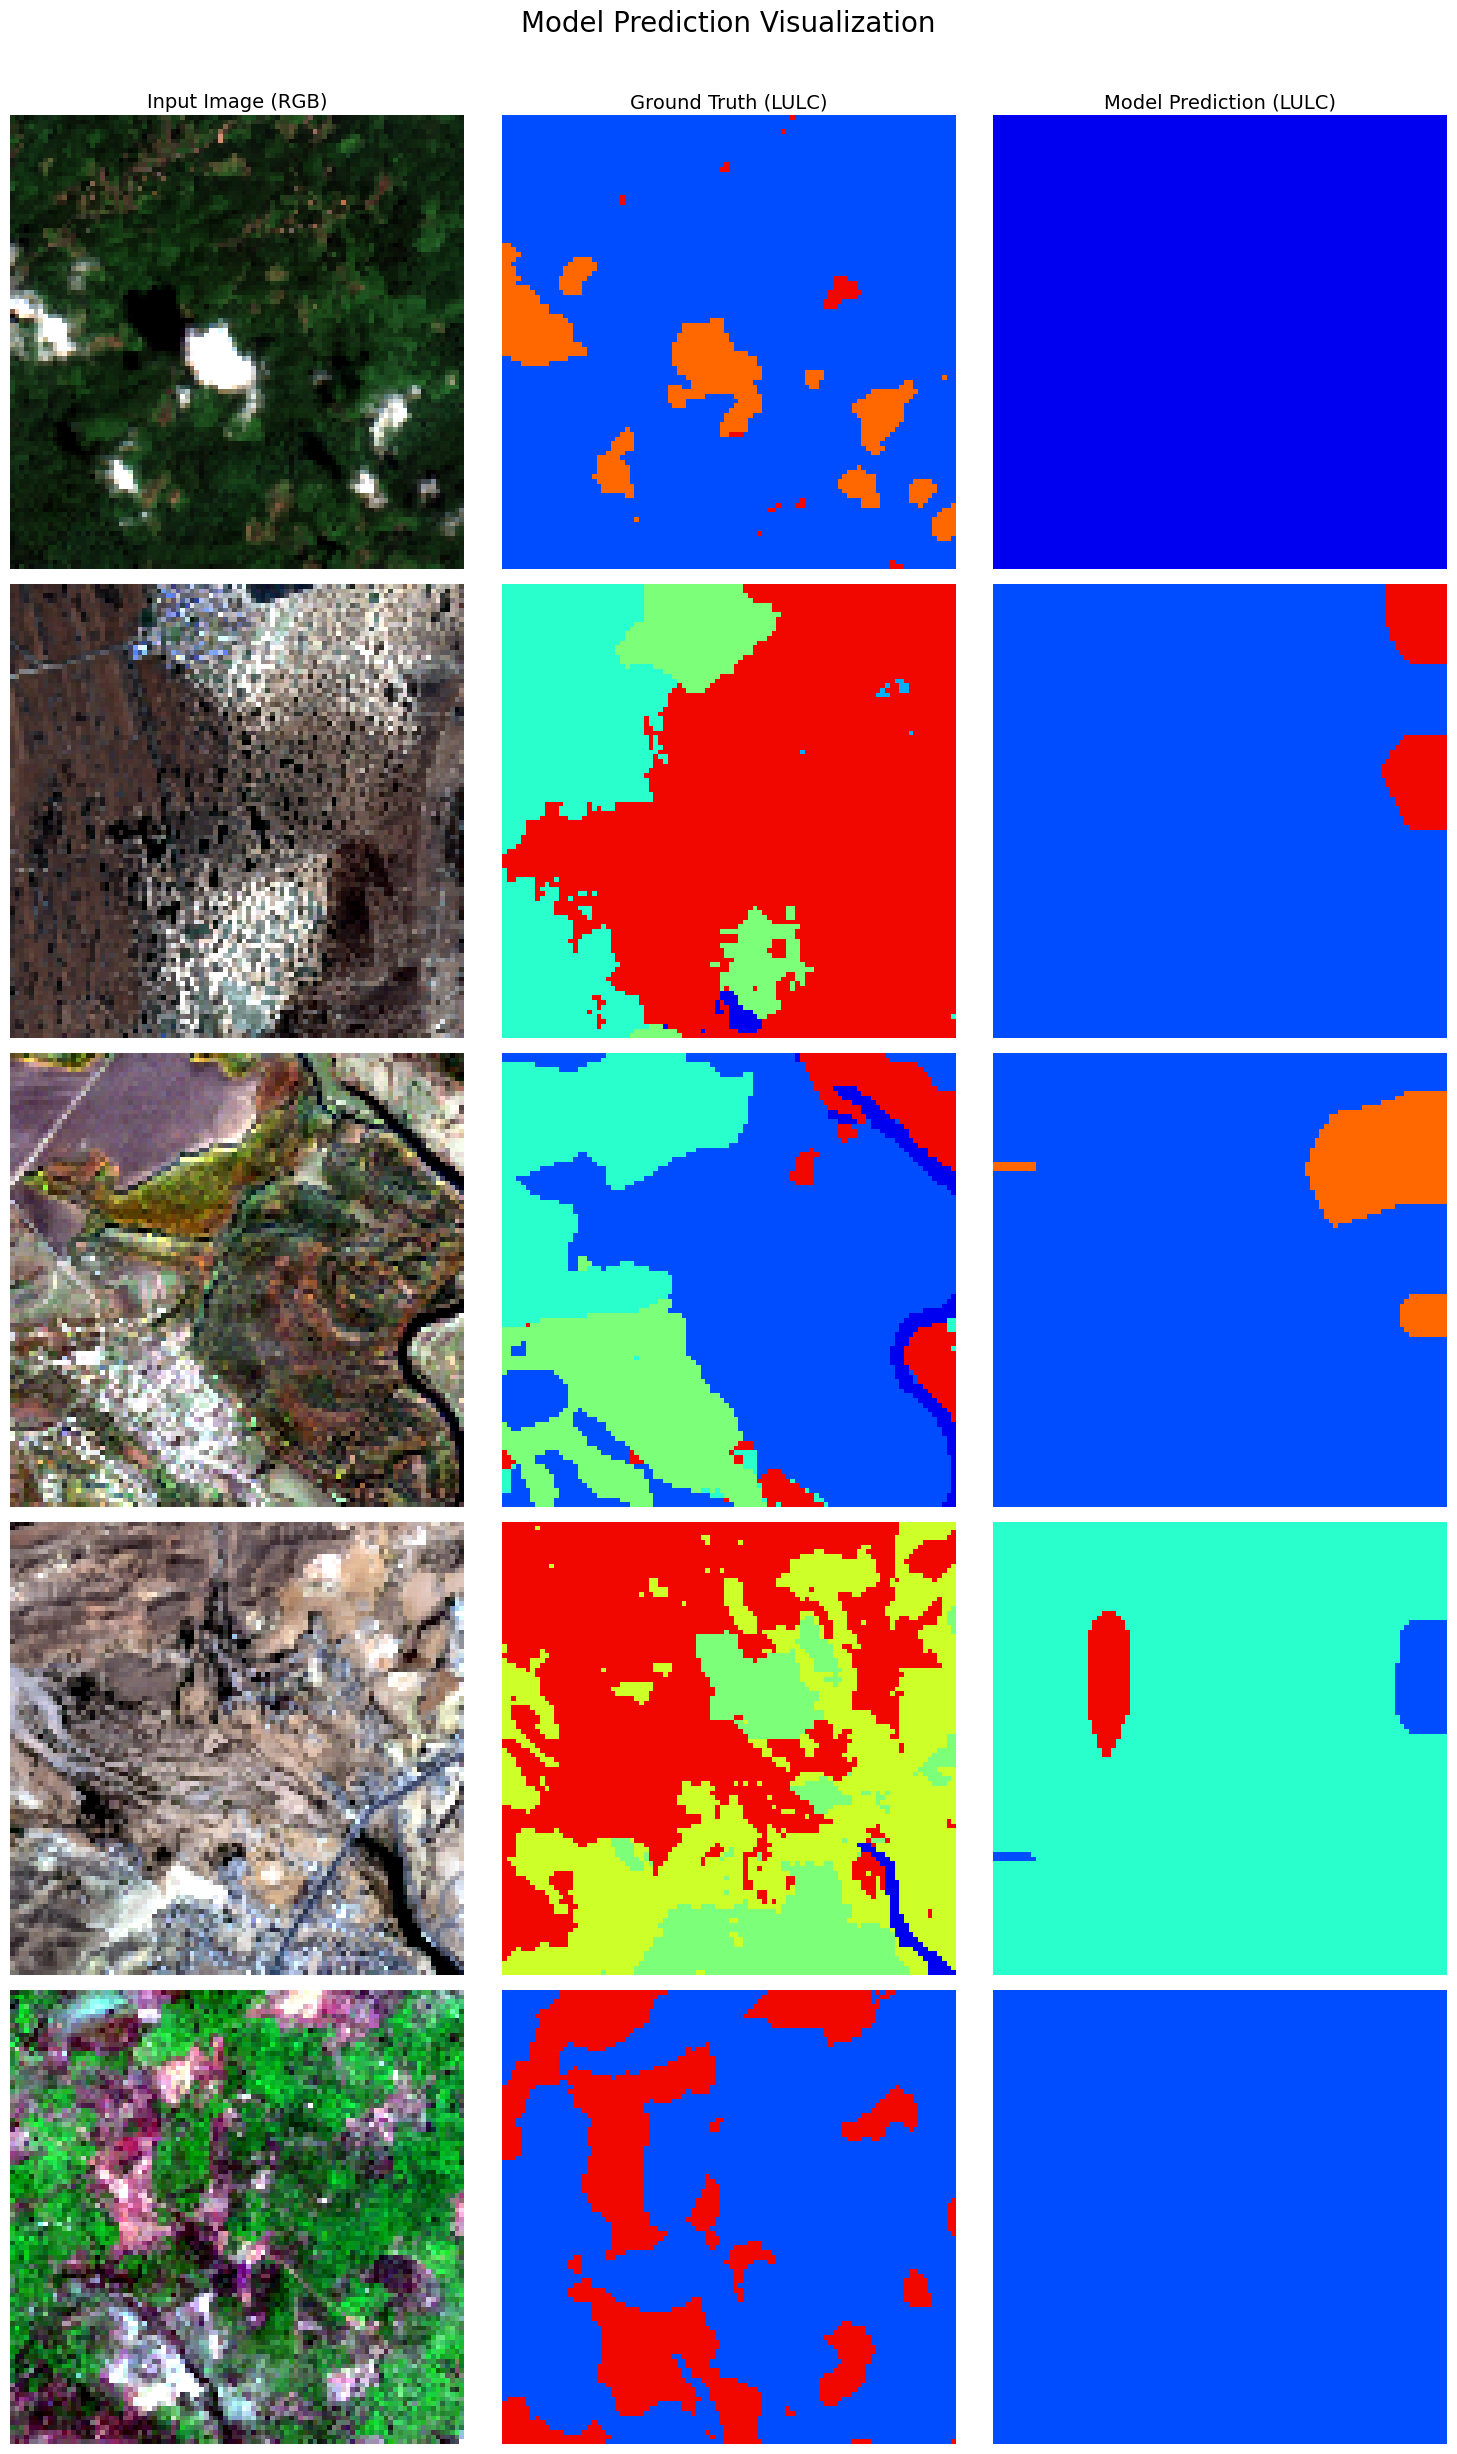

In [6]:
import matplotlib.pyplot as plt
import torch

print("\n🖼️ Visualizing model predictions on one batch...")

# A helper function to stretch contrast for better visualization
def normalize_for_plot(tensor):
    # For each channel, scale values to be between 0 and 1
    normalized_tensor = torch.zeros_like(tensor)
    for c in range(tensor.shape[0]):
        channel = tensor[c]
        # Clip values to the 2nd and 98th percentile to remove outliers
        min_val = torch.quantile(channel, 0.02)
        max_val = torch.quantile(channel, 0.98)
        # Scale to [0, 1]
        normalized_channel = (channel - min_val) / (max_val - min_val)
        # Clamp to ensure values are strictly in [0, 1] range
        normalized_tensor[c] = torch.clamp(normalized_channel, 0, 1)
    return normalized_tensor


# Get a single batch from the validation dataloader
vis_batch = next(iter(val_dataloader))
pixel_values = vis_batch['pixel_values'].to(DEVICE)
labels = vis_batch['labels'].to(DEVICE)

model.eval()
with torch.no_grad():
    # The model expects a 5D input, so we add a dummy time dimension
    output = model(pixel_values.unsqueeze(2))

# Get the predicted class for each pixel
predictions = torch.argmax(outputs, dim=1)

# Move data to CPU for plotting
pixel_values = pixel_values.cpu()
labels = labels.cpu()
predictions = predictions.cpu()

# Plot the results
n_images = 5
fig, axes = plt.subplots(n_images, 3, figsize=(15, n_images * 5))
fig.suptitle("Model Prediction Visualization", fontsize=20)
axes[0, 0].set_title("Input Image (RGB)", fontsize=14)
axes[0, 1].set_title("Ground Truth (LULC)", fontsize=14)
axes[0, 2].set_title("Model Prediction (LULC)", fontsize=14)

for i in range(n_images):
    # --- FIX IS HERE ---
    # 1. Get the full 6-channel image
    image_6_channels = pixel_values[i]
    
    # 2. Select the channels for an RGB image.
    # Our input bands are [B, G, R, NIR, SWIR1, SWIR2], so indices are [2, 1, 0] for R, G, B
    rgb_image = image_6_channels[[2, 1, 0], :, :]
    
    # 3. Normalize for better contrast and permute for plotting
    rgb_image_plot = normalize_for_plot(rgb_image).permute(1, 2, 0)
    
    axes[i, 0].imshow(rgb_image_plot)
    axes[i, 0].axis('off')
    
    axes[i, 1].imshow(labels[i], cmap='jet', vmin=0, vmax=NUM_LULC_CLASSES-1)
    axes[i, 1].axis('off')
    
    axes[i, 2].imshow(predictions[i], cmap='jet', vmin=0, vmax=NUM_LULC_CLASSES-1)
    axes[i, 2].axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

In [7]:
# Define a path to save the model
SAVE_PATH = "unet_lulc_model.pth"

# Save the model's state dictionary
torch.save(model.state_dict(), SAVE_PATH)

print(f"✅ Model saved to {SAVE_PATH}")

# You can later load it like this:
# model.load_state_dict(torch.load(SAVE_PATH))

✅ Model saved to unet_lulc_model.pth
